In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patches as patches
from scipy.interpolate import interp2d
%matplotlib inline
plt.rcParams['font.size'] = 7

In [2]:
def enlarge(x0):
    """ Extend the axis: enlarge(vector) """
    if isinstance(x0, list):
        x = np.array(x0)
    else:
        x = x0-0
    new_x = np.zeros(np.size(x)+1)
    new_x[1:-1] = (x[1:]+x[:-1])/2
    new_x[0] = 2*new_x[1]-new_x[2]
    new_x[-1] = 2*new_x[-2]-new_x[-3]
    return new_x

def make_theme(ax, case=1):
    """ Standard theme for plotting """
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(0.5)
    if case==1:
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.tick_params(which='major', direction='in', left=True, bottom=True, top=True, right=True, width=0.5, length=3)
        ax.tick_params(which='minor', direction='in', left=True, bottom=True, top=True, right=True, width=0.5, length=1.5)
    elif case==2:
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.tick_params(which='major', direction='in', left=True, bottom=True, top=True, right=True, width=0.5, length=3)
        ax.tick_params(which='minor', direction='in', left=True, bottom=True, top=True, right=True, width=0.5, length=1.5)

def plot_curve(Q, T, ax):
    """ Plot one spectrum with fitting """
    # Load the data and fit
    data = np.loadtxt('./data/Q({:.4f},{:.4f},{:.2f})_T{}.txt'.format(Q[0],Q[1],Q[2],round(T)))
    fit = np.loadtxt('./fit/Q({:.4f},{:.4f},{:.2f})_T{}.txt'.format(Q[0],Q[1],Q[2],round(T)))
    # Plot the data
    ax.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='o', ls='none', color='dimgrey',
                markerfacecolor='w', markersize=3, markeredgewidth=0.5, lw=0.5, elinewidth=0.5, zorder=10)
    # Plot the fit
    ax.plot(fit[:,0], np.sum(fit[:,1:], axis=1), color='dimgrey', lw=1, zorder=20) # Summed
    ax.plot(fit[:,0], fit[:,1], color='C0', ls='--', lw=0.5, zorder=21) # Quasi-elastic
    ax.plot(fit[:,0], fit[:,2], color='C2', ls='--', lw=0.5, zorder=23) # Transverse mode
    ax.plot(fit[:,0], fit[:,4], color='C4', ls='--', lw=0.5, zorder=23) # Magnetic continuum
    if np.max(fit[:,3])>1e-6:
        ax.plot(fit[:,0], fit[:,3], color='C3', ls='-', lw=0.5, zorder=30) # Longitudinal mode
        ax.fill_between(fit[:,0], fit[:,3], y2=0., color='C3', alpha=0.2, zorder=-10)
    # Adjust the axis
    make_theme(ax, case=1)
    ax.axhline(y=0, ls='--', zorder=100, color='grey', lw=1)
    ax.axvline(x=0, ls='--', zorder=0, color='grey', lw=0.5)
    ax.set_xlim(-50, 300)
    ax.set_xticks([0, 100, 200, 300])

# Ldep

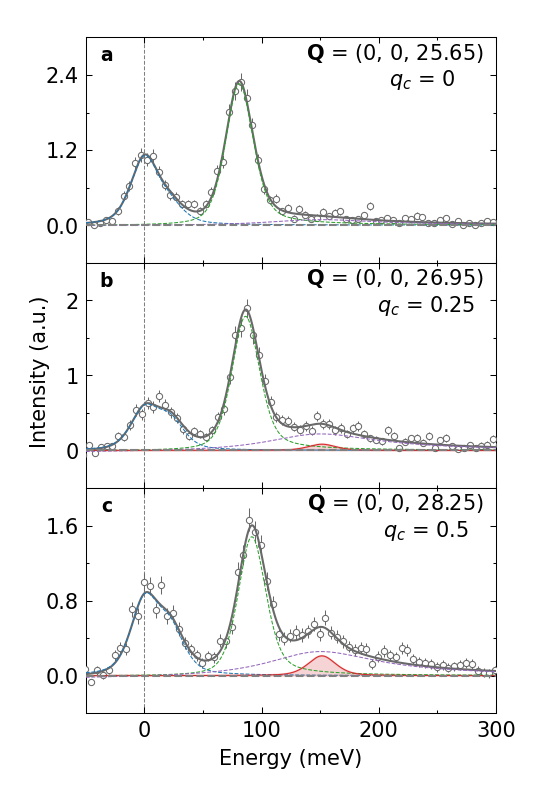

In [3]:
fig, axs = plt.subplots(3, 1, figsize=[3.375, 3.375*1.5], dpi=150, sharex=True,
                        gridspec_kw=dict(hspace=0., bottom=0.08, top=0.97, left=0.14, right=0.95))

# Plot the data and fit
for ax, L, qc in zip(axs, [25.65,26.95,28.25], [0,0.25,0.5]):
    plot_curve((0.,0.,L), 20, ax)

# Adjust the axis
axs[0].text(0.97, 0.87, '$\\bf{Q}$ = (0, 0, 25.65)\n$q_c$ = 0     ', transform=axs[0].transAxes, verticalalignment='center', horizontalalignment='right')
axs[1].text(0.97, 0.87, '$\\bf{Q}$ = (0, 0, 26.95)\n$q_c$ = 0.25  ', transform=axs[1].transAxes, verticalalignment='center', horizontalalignment='right')
axs[2].text(0.97, 0.87, '$\\bf{Q}$ = (0, 0, 28.25)\n$q_c$ = 0.5   ', transform=axs[2].transAxes, verticalalignment='center', horizontalalignment='right')

axs[0].set_ylim(-0.6,3)
axs[0].set_yticks([0, 1.2, 2.4])
axs[1].set_ylim(-0.5,2.5)
axs[1].set_yticks([0, 1, 2])
axs[2].set_ylim(-0.4,2)
axs[2].set_yticks([0, 0.8, 1.6])
axs[2].set_xlabel('Energy (meV)')
for ax in axs[:2]: ax.tick_params(labelbottom=False)

ax = fig.add_axes([0., 0., 1, 1])
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.text(.05, 0.53, 'Intensity (a.u.)', rotation='vertical', horizontalalignment='center', verticalalignment='center')
for ax, label in zip(axs,['a','b','c']):
    ax.text(0.05, 0.92, label, fontdict=dict(fontsize=9), transform=ax.transAxes, fontweight='bold', horizontalalignment='center', verticalalignment='center')

# Dispersion
- Load the data

In [4]:
keys = ['H','K','L','Qv','T','TM_center','TM_HWHM','LM_center','LM_HWHM']

### Disp1 for qc=0
# Load the info
Disp1_info = np.loadtxt('Disp_info_Qc0.txt')
Disp1 = dict(Ev=np.arange(-300.,501.,5.))
for key, info in zip(keys, Disp1_info.T):
    Disp1[key] = info
# Make labels for high symmetry points
Disp1['Qlabel'] = [Disp1['Qv'][Qid] for Qid in [0,4,12,16,20]]
# Load the data and produce colormap
Is = []
for H, K, L in zip(Disp1['H'], Disp1['K'], Disp1['L']):
    data = np.loadtxt('data/Q({:.4f},{:.4f},{:.2f})_T20.txt'.format(H,K,L))
    Is.append(np.interp(Disp1['Ev'], data[:,0], data[:,1]))
Disp1['Intensity'] = np.vstack(Is).T

### Disp2 for qc=0.5
# Load the info
Disp2_info = np.loadtxt('Disp_info_Qc0p5.txt')
Disp2 = dict(Ev=np.arange(-300.,501.,5.), Qlabel=Disp1['Qlabel'])
for key, info in zip(keys,Disp2_info.T):
    Disp2[key] = info
# Load the data and produce colormap
Is = []
for H, K, L in zip(Disp2['H'], Disp2['K'], Disp2['L']):
    data = np.loadtxt('data/Q({:.4f},{:.4f},{:.2f})_T20.txt'.format(H,K,L))
    Is.append(np.interp(Disp2['Ev'], data[:,0], data[:,1]))
Disp2['Intensity'] = np.vstack(Is).T

- Load the calculation

Polarization induced prefactor for calculations: $I_x + I_y$ & $I_z$

$Q=(0, 0, 28.25)$ prefactors: $x+y=2.526, z=1.0525$

$Q=(-1, -1, 25.65)$ prefactors: $x+y=3.1324, z=0.4319$

$Q=(-0.5, -0.5, 25.65)$ prefactors: $x+y=2.9496, z=0.6201$

In [5]:
Pxy_Qc0p5, Pz_Qc0p5 = 2.526, 1.0525
Pxy_Qc0, Pz_Qc0 = (3.1324+2.9496)/2., (0.4319+0.6201)/2.

# Load the calculation
Qv = np.loadtxt('calculation/Qv.txt')[:,2]
Ev = np.loadtxt('calculation/Ev.txt')
SQW = np.loadtxt('calculation/T21_con.txt')

# Change Q into same interval
Qstep = np.mean(np.diff(Qv))
new_Qv = np.arange(0, Qv[-1]+Qstep*0.9, Qstep)

### Dispersion for qc=0
SQW1 = dict(Ev=Ev, Qv=new_Qv)
# 2d interp for imshow
f = interp2d(Qv, Ev, SQW[:,0].reshape(2500,449)*Pxy_Qc0+SQW[:,1].reshape(2500,449)*Pz_Qc0, kind='cubic')
SQW1['Intensity'] = f(new_Qv, Ev)

### Dispersion for qc=0.5
SQW2 = dict(Ev=Ev, Qv=new_Qv)
# 2d interp for imshow
f = interp2d(Qv, Ev, SQW[:,2].reshape(2500,449)*Pxy_Qc0p5+SQW[:,3].reshape(2500,449)*Pz_Qc0p5, kind='cubic')
SQW2['Intensity'] = f(new_Qv, Ev)

- Plot the figure

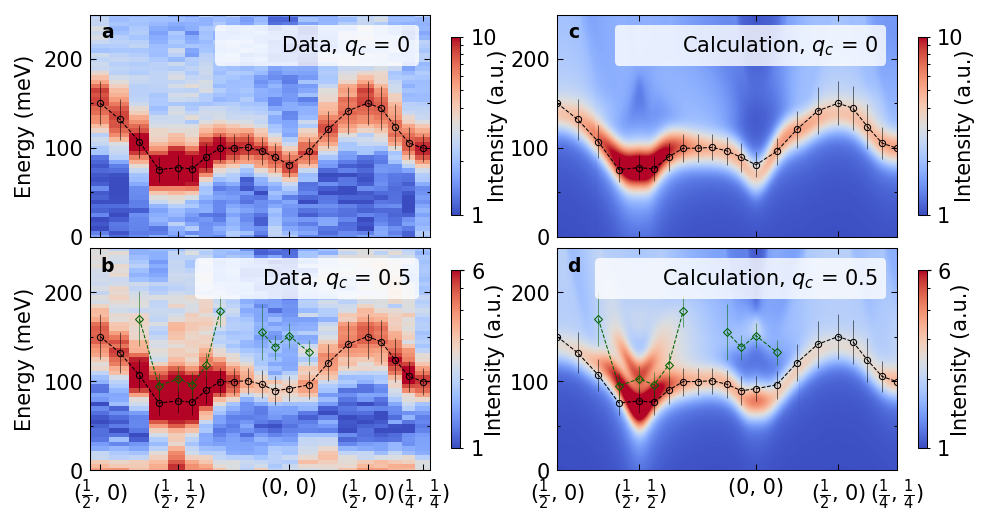

In [6]:
fig, axs = plt.subplots(2, 2, figsize=[3.375*2, 3.375], dpi=150, sharex='col', sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.05, bottom=0.07, top=0.97, left=0.1, right=0.98))
cmap = 'coolwarm' # RdBu, terrain, coolwarm
axs = axs.T.ravel()
cbars = [[] for _ in range(4)]

# Data colorplot
art = axs[0].pcolormesh(enlarge(Disp1['Qv']), enlarge(Disp1['Ev']), Disp1['Intensity']+1, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10), zorder=0)
cbars[0] = fig.colorbar(art, ax=axs[0], shrink=0.8, format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,11))
art = axs[1].pcolormesh(enlarge(Disp2['Qv']), enlarge(Disp2['Ev']), Disp2['Intensity']+1, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=6), zorder=0)
cbars[1] = fig.colorbar(art, ax=axs[1], shrink=0.8, format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,6))

# Calculation colorplot
extent = [SQW1['Qv'][0], SQW1['Qv'][-1], SQW1['Ev'][0], SQW1['Ev'][-1]]
art = axs[2].imshow(SQW1['Intensity']*50.+1., origin='lower', extent=extent, aspect='auto', norm=colors.LogNorm(vmin=1, vmax=10), cmap=cmap)
cbars[2] = fig.colorbar(art, ax=axs[2], shrink=0.8, format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,11))
art = axs[3].imshow(SQW2['Intensity']*50.+1., origin='lower', extent=extent, aspect='auto', norm=colors.LogNorm(vmin=1, vmax=6), cmap=cmap)
cbars[3] = fig.colorbar(art, ax=axs[3], shrink=0.8, format=ticker.LogFormatter(6, labelOnlyBase=True), ticks=np.arange(1,6))

# Fitting results
errorbar_params = dict(fillstyle='none', ls='--', markersize=3, markeredgewidth=0.5, lw=0.5, elinewidth=0.25)
axs[0].errorbar(Disp1['Qv'], Disp1['TM_center'], yerr=Disp1['TM_HWHM'], fmt='o', color='k', **errorbar_params)
axs[2].errorbar(Disp1['Qv'], Disp1['TM_center'], yerr=Disp1['TM_HWHM'], fmt='o', color='k', **errorbar_params)
axs[1].errorbar(Disp2['Qv'], Disp2['TM_center'], yerr=Disp2['TM_HWHM'], fmt='o', color='k', **errorbar_params)
axs[1].errorbar(Disp2['Qv'], Disp2['LM_center'], yerr=Disp2['LM_HWHM'], fmt='D', color='darkgreen', **errorbar_params)
axs[3].errorbar(Disp1['Qv'], Disp2['TM_center'], yerr=Disp2['TM_HWHM'], fmt='o', color='k', **errorbar_params)
axs[3].errorbar(Disp1['Qv'], Disp2['LM_center'], yerr=Disp2['LM_HWHM'], fmt='D', color='darkgreen', **errorbar_params)

# Adjust the axis
for ax in axs:
    make_theme(ax, case=2)
    ax.tick_params(labelleft=True)
    ax.set_xticks(Disp1['Qlabel'])
    ax.set_xticklabels([r'($\frac{1}{2}$, 0)', r'($\frac{1}{2}$, $\frac{1}{2}$)', r'(0, 0)', r'($\frac{1}{2}$, 0)', r'($\frac{1}{4}$, $\frac{1}{4}$)'])
axs[0].set_ylim(0,250)
axs[0].set_yticks([0, 100, 200])
axs[2].set_xlim(0,Disp1['Qlabel'][-1])
for ax in axs[:2]:
    ax.set_ylabel('Energy (meV)')

# Set the legend
axs[0].plot(np.nan, np.nan, ls='none', label=r'Data, $q_c$ = 0')
axs[1].plot(np.nan, np.nan, ls='none', label=r'Data, $q_c$ = 0.5')
axs[2].plot(np.nan, np.nan, ls='none', label=r'Calculation, $q_c$ = 0')
axs[3].plot(np.nan, np.nan, ls='none', label=r'Calculation, $q_c$ = 0.5')
for ax in axs: ax.legend(loc='upper right', framealpha=0.8, facecolor='w', edgecolor='none')

for ax, label in zip(axs,['a','b','c','d']):
    ax.text(0.05, 0.92, label, fontdict=dict(fontsize=9), transform=ax.transAxes, fontweight='bold', horizontalalignment='center', verticalalignment='center')

cbars[0].set_label('Intensity (a.u.)', labelpad=-4)
cbars[1].set_label('Intensity (a.u.)', labelpad=0)
cbars[2].set_label('Intensity (a.u.)', labelpad=-4)
cbars[3].set_label('Intensity (a.u.)', labelpad=0)
for cbar in cbars:
    cbar.outline.set_linewidth(0.5)
    cbar.ax.tick_params(width=0.5, length=1.5)
    cbar.ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())

# Tdep
- Load the data

In [7]:
keys = ['Qid','H','K','L','Tv','e_amplitude','e_amplitude_err','TM_center','TM_HWHM','LM_center','LM_HWHM']

# Load the info
Tdep_info = np.loadtxt('Tdep_info.txt')
Tdeps = []
for nQ in range(8):
    # There are 8 Q points in total
    choose = Tdep_info[:,0]==nQ
    # Read the data
    Tdep = dict()
    for nkey, key in enumerate(keys):
        Tdep[key] = Tdep_info[choose,nkey]
    # Produce colormap
    for H,K,L,T in zip(Tdep['H'], Tdep['K'], Tdep['L'], Tdep['Tv']):
        data = np.loadtxt('./data/Q({:.4f},{:.4f},{:.2f})_T{}.txt'.format(H,K,L,int(T)))
        if 'Ev' not in Tdep.keys():
            Tdep['Ev'] = data[:,0]
            Tdep['Intensity'] = [data[:,1]]
        else:
            Tdep['Intensity'].append(np.interp(Tdep['Ev'], data[:,0], data[:,1]))
    Tdep['Intensity'] = np.vstack(Tdep['Intensity']).T
    Tdeps.append(Tdep)

- Load the calculations

In [8]:
keys = ['Qid','H','K','qc','Tv','TM_center','LM_center']

# Load the calculation
Tdep_calc = np.loadtxt('calculation/Tdep.txt')

# Q=(0,0), qc=0.5, Qid=4
Tdep4_calc = dict()
choose = Tdep_calc[:,0]==4
for nkey, key in enumerate(keys): Tdep4_calc[key] = Tdep_calc[choose,nkey]

# Q=(0.5,0.5), qc=0.5, Qid=5
Tdep5_calc = dict()
choose = Tdep_calc[:,0]==5
for nkey, key in enumerate(keys): Tdep5_calc[key] = Tdep_calc[choose,nkey]

- Plot the figure

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


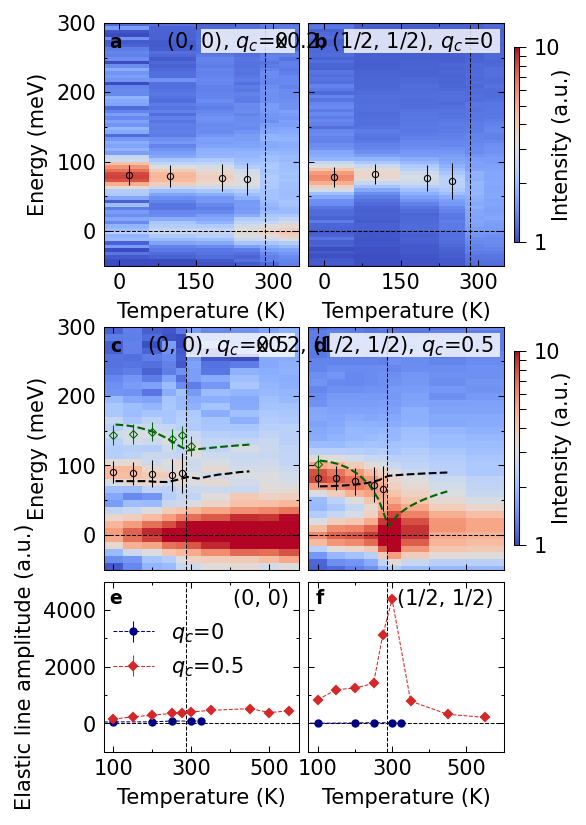

In [9]:
fig = plt.figure(figsize=[6.75/2, 6.75*0.8], dpi=150)
gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.15, wspace=0.05, bottom=0.67, top=0.97, left=0.12, right=0.91)
gs2 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.15, wspace=0.05, bottom=0.295, top=0.595, left=0.12, right=0.91)
gs3 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.15, wspace=0.05, bottom=0.07, top=0.28, left=0.12, right=0.91)
gs4 = fig.add_gridspec(nrows=1, ncols=1, bottom=0.7, top=0.94, left=0.93, right=0.94)
gs5 = fig.add_gridspec(nrows=1, ncols=1, bottom=0.325, top=0.565, left=0.93, right=0.94)
axs = [fig.add_subplot(gs) for gs in gs1] + [fig.add_subplot(gs) for gs in gs2] + [fig.add_subplot(gs) for gs in gs3] + [fig.add_subplot(gs4[0])] + [fig.add_subplot(gs5[0])]

cmap = 'coolwarm'

# Colorplot & TM/LM
for nax, (ax, Tdep) in enumerate(zip(axs, Tdeps[:2]+Tdeps[4:6])):
    if nax in [1, 3]:
        art = ax.pcolormesh(enlarge(Tdep['Tv']), enlarge(Tdep['Ev']), Tdep['Intensity']*0.2+1, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10)) # x0.2 for (0.5,0.5)
    else:
        art = ax.pcolormesh(enlarge(Tdep['Tv']), enlarge(Tdep['Ev']), Tdep['Intensity']+1, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10))
    ax.errorbar(Tdep['Tv'], Tdep['TM_center'], yerr=Tdep['TM_HWHM'], fmt='o', fillstyle='none', ls='none', color='k', elinewidth=0.5, lw=1, markersize=3, markeredgewidth=0.5)
    ax.errorbar(Tdep['Tv'], Tdep['LM_center'], yerr=Tdep['LM_HWHM'], fmt='D', fillstyle='none', ls='none', color='darkgreen', elinewidth=0.5, lw=1, markersize=3, markeredgewidth=0.5)

# Elastic line intensity
for ax, data1, data2 in zip(axs[4:], Tdeps[:2], Tdeps[4:6]):
    ax.errorbar(data1['Tv'], data1['e_amplitude'], yerr=data1['e_amplitude_err'], fmt='o', color='navy', ls='--', lw=0.5, markersize=3, label='$q_c$=0')
    ax.errorbar(data2['Tv'], data2['e_amplitude'], yerr=data2['e_amplitude_err'], fmt='D', color='C3', ls='--', lw=0.5, markersize=2.8, label='$q_c$=0.5')
    
# Calculations
axs[2].plot(Tdep4_calc['Tv'], Tdep4_calc['TM_center'], color='k', ls='--', lw=1)
axs[2].plot(Tdep4_calc['Tv'], Tdep4_calc['LM_center'], color='darkgreen', ls='--', lw=1)
axs[3].plot(Tdep5_calc['Tv'], Tdep5_calc['TM_center'], color='k', ls='--', lw=1)
axs[3].plot(Tdep5_calc['Tv'], Tdep5_calc['LM_center'], color='darkgreen', ls='--', lw=1)

# Adjust the axis
for ax in axs[:6]:
    ax.axhline(y=0, ls='--', color='k', lw=0.5)
    ax.axvline(x=285, ls='--', color='k', lw=0.5)
    make_theme(ax, case=1)

for ax in axs[:4]:
    ax.set_ylim(-50,300)
    ax.set_yticks([0, 100, 200, 300])

for ax in axs[4:6]:
    ax.set_ylim(-1000,5000)
    ax.set_yticks([0, 2000, 4000])

axs[4].set_xlim(axs[2].get_xlim())
axs[5].set_xlim(axs[3].get_xlim())
for ax in axs[:2]:
    ax.set_xticks([0, 150, 300])
    ax.set_xlabel('Temperature (K)')
for ax in axs[2:-2]:
    ax.set_xticks([100, 300, 500])
for ax in axs[4:-2]:
    ax.set_xlabel('Temperature (K)')
    
axs[0].tick_params(labelbottom=True,  labelleft=True)
axs[1].tick_params(labelbottom=True,  labelleft=False)
axs[2].tick_params(labelbottom=False, labelleft=True)
axs[3].tick_params(labelbottom=False, labelleft=False)
axs[4].tick_params(labelbottom=True,  labelleft=True)
axs[5].tick_params(labelbottom=True,  labelleft=False)
axs[0].set_ylabel('Energy (meV)')
axs[2].set_ylabel('Energy (meV)')
axs[4].set_ylabel('Elastic line amplitude (a.u.)')

for ax, dx in zip(axs[:4], [0,0.32,0.08,0.39]):
    r1 = patches.Rectangle((0.5-dx,0.875),0.48+dx,0.1, color='w', lw=0, alpha=0.8, zorder=3, transform=ax.transAxes)
    ax.add_patch(r1)
axs[0].text(0.95, 0.92, r'(0, 0), $q_c$=0', transform=axs[0].transAxes, horizontalalignment='right', verticalalignment='center')
axs[1].text(0.95, 0.92, r'x0.2, (1/2, 1/2), $q_c$=0', transform=axs[1].transAxes, horizontalalignment='right', verticalalignment='center')
axs[2].text(0.95, 0.92, r'(0, 0), $q_c$=0.5', transform=axs[2].transAxes, horizontalalignment='right', verticalalignment='center')
axs[3].text(0.95, 0.92, r'x0.2, (1/2, 1/2), $q_c$=0.5', transform=axs[3].transAxes, horizontalalignment='right', verticalalignment='center')
axs[4].text(0.95, 0.9, r'(0, 0)', transform=axs[4].transAxes, horizontalalignment='right', verticalalignment='center')
axs[5].text(0.95, 0.9, r'(1/2, 1/2)', transform=axs[5].transAxes, horizontalalignment='right', verticalalignment='center')
for ax, label in zip(axs, ['a','b','c','d']):
    ax.text(0.06, 0.92, label, fontdict=dict(fontsize=9), transform=ax.transAxes, fontweight='bold', horizontalalignment='center', verticalalignment='center')
for ax, label in zip(axs[4:], ['e','f']):
    ax.text(0.06, 0.9, label, fontdict=dict(fontsize=9), transform=ax.transAxes, fontweight='bold', horizontalalignment='center', verticalalignment='center')
axs[4].legend(loc='center left', frameon=False, bbox_to_anchor=(-0.05, 0.5, 0.1, 0.2))

cbar = fig.colorbar(art, cax=axs[-2], format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,11))
cbar.set_label('Intensity (a.u.)', labelpad=-4)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(width=0.5)

cbar = fig.colorbar(art, cax=axs[-1], format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,11))
cbar.set_label('Intensity (a.u.)', labelpad=-4)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(width=0.5)

# Tdep more

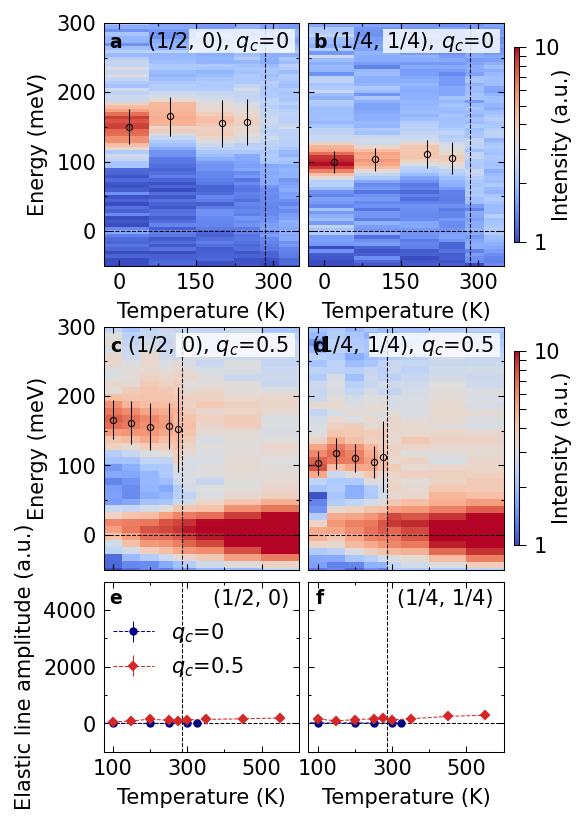

In [10]:
fig = plt.figure(figsize=[6.75/2, 6.75*0.8], dpi=150)
gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.15, wspace=0.05, bottom=0.67, top=0.97, left=0.12, right=0.91)
gs2 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.15, wspace=0.05, bottom=0.295, top=0.595, left=0.12, right=0.91)
gs3 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.15, wspace=0.05, bottom=0.07, top=0.28, left=0.12, right=0.91)
gs4 = fig.add_gridspec(nrows=1, ncols=1, bottom=0.7, top=0.94, left=0.93, right=0.94)
gs5 = fig.add_gridspec(nrows=1, ncols=1, bottom=0.325, top=0.565, left=0.93, right=0.94)
axs = [fig.add_subplot(gs) for gs in gs1] + [fig.add_subplot(gs) for gs in gs2] + [fig.add_subplot(gs) for gs in gs3] + [fig.add_subplot(gs4[0])] + [fig.add_subplot(gs5[0])]

cmap = 'coolwarm'

# Colorplot & TM/LM
for nax, (ax, Tdep) in enumerate(zip(axs, Tdeps[2:4]+Tdeps[6:])):
    art = ax.pcolormesh(enlarge(Tdep['Tv']), enlarge(Tdep['Ev']), Tdep['Intensity']+1, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10))
    ax.errorbar(Tdep['Tv'], Tdep['TM_center'], yerr=Tdep['TM_HWHM'], fmt='o', fillstyle='none', ls='none', color='k', elinewidth=0.5, lw=1, markersize=3, markeredgewidth=0.5)

# Elastic line intensity
for ax, data1, data2 in zip(axs[4:], Tdeps[2:4], Tdeps[6:]):
    ax.errorbar(data1['Tv'], data1['e_amplitude'], yerr=data1['e_amplitude_err'], fmt='o', color='navy', ls='--', lw=0.5, markersize=3, label='$q_c$=0')
    ax.errorbar(data2['Tv'], data2['e_amplitude'], yerr=data2['e_amplitude_err'], fmt='D', color='C3', ls='--', lw=0.5, markersize=2.8, label='$q_c$=0.5')

# Adjust the axis
for ax in axs[:6]:
    ax.axhline(y=0, ls='--', color='k', lw=0.5)
    ax.axvline(x=285, ls='--', color='k', lw=0.5)
    make_theme(ax, case=1)

for ax in axs[:4]:
    ax.set_ylim(-50,300)
    ax.set_yticks([0, 100, 200, 300])

for ax in axs[4:6]:
    ax.set_ylim(-1000,5000)
    ax.set_yticks([0, 2000, 4000])

axs[4].set_xlim(axs[2].get_xlim())
axs[5].set_xlim(axs[3].get_xlim())
for ax in axs[:2]:
    ax.set_xticks([0, 150, 300])
    ax.set_xlabel('Temperature (K)')
for ax in axs[2:-2]:
    ax.set_xticks([100, 300, 500])
for ax in axs[4:-2]:
    ax.set_xlabel('Temperature (K)')
    
axs[0].tick_params(labelbottom=True,  labelleft=True)
axs[1].tick_params(labelbottom=True,  labelleft=False)
axs[2].tick_params(labelbottom=False, labelleft=True)
axs[3].tick_params(labelbottom=False, labelleft=False)
axs[4].tick_params(labelbottom=True,  labelleft=True)
axs[5].tick_params(labelbottom=True,  labelleft=False)
axs[0].set_ylabel('Energy (meV)')
axs[2].set_ylabel('Energy (meV)')
axs[4].set_ylabel('Elastic line amplitude (a.u.)')

for ax, dx in zip(axs[:4], [0.06,0.12,0.13,0.19]):
    r1 = patches.Rectangle((0.5-dx,0.875),0.48+dx,0.1, color='w', lw=0, alpha=0.8, zorder=3, transform=ax.transAxes)
    ax.add_patch(r1)
axs[0].text(0.95, 0.92, r'(1/2, 0), $q_c$=0', transform=axs[0].transAxes, horizontalalignment='right', verticalalignment='center')
axs[1].text(0.95, 0.92, r'(1/4, 1/4), $q_c$=0', transform=axs[1].transAxes, horizontalalignment='right', verticalalignment='center')
axs[2].text(0.95, 0.92, r'(1/2, 0), $q_c$=0.5', transform=axs[2].transAxes, horizontalalignment='right', verticalalignment='center')
axs[3].text(0.95, 0.92, r'(1/4, 1/4), $q_c$=0.5', transform=axs[3].transAxes, horizontalalignment='right', verticalalignment='center')
axs[4].text(0.95, 0.9, r'(1/2, 0)', transform=axs[4].transAxes, horizontalalignment='right', verticalalignment='center')
axs[5].text(0.95, 0.9, r'(1/4, 1/4)', transform=axs[5].transAxes, horizontalalignment='right', verticalalignment='center')
for ax, label in zip(axs, ['a','b','c','d']):
    ax.text(0.06, 0.92, label, fontdict=dict(fontsize=9), transform=ax.transAxes, fontweight='bold', horizontalalignment='center', verticalalignment='center')
for ax, label in zip(axs[4:], ['e','f']):
    ax.text(0.06, 0.9, label, fontdict=dict(fontsize=9), transform=ax.transAxes, fontweight='bold', horizontalalignment='center', verticalalignment='center')
axs[4].legend(loc='center left', frameon=False, bbox_to_anchor=(-0.05, 0.5, 0.1, 0.2))
    
cbar = fig.colorbar(art, cax=axs[-2], format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,11))
cbar.set_label('Intensity (a.u.)', labelpad=-4)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(width=0.5)

cbar = fig.colorbar(art, cax=axs[-1], format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,11))
cbar.set_label('Intensity (a.u.)', labelpad=-4)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(width=0.5)

# Fitting

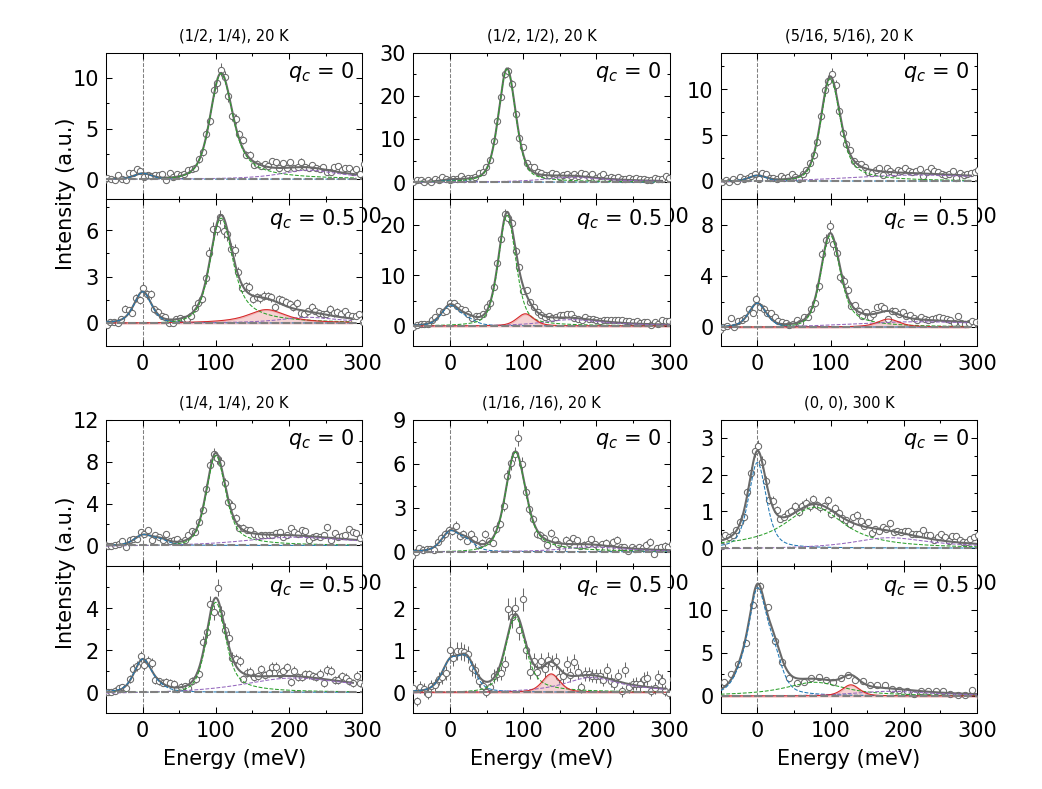

In [11]:
fig = plt.figure(figsize=[3.375*2, 3.375*1.5], dpi=150)
gs = fig.add_gridspec(nrows=2, ncols=3, left=0.09, right=0.95, top=0.95, bottom=0.08, wspace=0.2, hspace=0.25)
axs = [[fig.add_subplot(g0) for g0 in g.subgridspec(2, 1, wspace=0.0, hspace=0.0)] for g in gs]

# Plot the data and fit
plot_curve((-0.5,-0.75,25.65), 20, axs[0][0])
plot_curve((-0.5,-0.25,28.25), 20, axs[0][1])
plot_curve((-0.5,-0.5,25.65), 20, axs[1][0])
plot_curve((-0.5,-0.5,28.25), 20, axs[1][1])
plot_curve((-0.6875,-0.6875,25.65), 20, axs[2][0])
plot_curve((-0.3125,-0.3125,28.25), 20, axs[2][1])
plot_curve((-0.75,-0.75,25.65), 20, axs[3][0])
plot_curve((-0.25,-0.25,28.25), 20, axs[3][1])
plot_curve((-0.9375,-0.9375,25.65), 20, axs[4][0])
plot_curve((-0.0625,-0.0625,28.25), 20, axs[4][1])
plot_curve((-1.,-1.,25.65), 300, axs[5][0])
plot_curve((0.,0.,28.25), 300, axs[5][1])

# Adjust the axis
for ax in axs:
    ax[0].text(0.97, 0.87, '$q_c$ = 0', transform=ax[0].transAxes, verticalalignment='center', horizontalalignment='right')
    ax[1].text(0.97, 0.87, '$q_c$ = 0.5', transform=ax[1].transAxes, verticalalignment='center', horizontalalignment='right')
    ax[1].tick_params(labelbottom=True)
axs[0][0].set_title('(1/2, 1/4), 20 K', fontsize=7)
axs[1][0].set_title('(1/2, 1/2), 20 K', fontsize=7)
axs[2][0].set_title('(5/16, 5/16), 20 K', fontsize=7)
axs[3][0].set_title('(1/4, 1/4), 20 K', fontsize=7)
axs[4][0].set_title('(1/16, /16), 20 K', fontsize=7)
axs[5][0].set_title('(0, 0), 300 K', fontsize=7)

axs[3][1].set_xlabel('Energy (meV)')
axs[4][1].set_xlabel('Energy (meV)')
axs[5][1].set_xlabel('Energy (meV)')

ax = fig.add_axes( [0., 0.5, 1, 0.5] )
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.text(.05, 0.53, "Intensity (a.u.)", rotation='vertical',
        horizontalalignment='center', verticalalignment='center')

ax = fig.add_axes( [0., 0., 1, 0.5] )
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.text(.05, 0.53, "Intensity (a.u.)", rotation='vertical',
        horizontalalignment='center', verticalalignment='center')

axs[0][0].set_ylim(-2,12.5)
axs[0][0].set_yticks([0,5,10])
axs[0][1].set_ylim(-1.5,8)
axs[0][1].set_yticks([0,3,6])
axs[1][0].set_ylim(-4,30)
axs[1][0].set_yticks([0,10,20,30])
axs[1][1].set_ylim(-4,25)
axs[1][1].set_yticks([0,10,20])
axs[2][0].set_ylim(-2,14)
axs[2][0].set_yticks([0,5,10])
axs[2][1].set_ylim(-1.5,10)
axs[2][1].set_yticks([0,4,8])
axs[3][0].set_ylim(-2,12)
axs[3][0].set_yticks([0,4,8,12])
axs[3][1].set_ylim(-1,6)
axs[3][1].set_yticks([0,2,4])
axs[4][0].set_ylim(-1,9)
axs[4][0].set_yticks([0,3,6,9])
axs[4][1].set_ylim(-0.5,3)
axs[4][1].set_yticks([0,1,2])
axs[5][0].set_ylim(-0.5,3.5)
axs[5][0].set_yticks([0,1,2,3])
axs[5][1].set_ylim(-2,15)
axs[5][1].set_yticks([0,5,10])

# Calculation

In [12]:
### Load the info
# Change Q points into same interval
Qv0 = np.loadtxt('calculation/Qv.txt')[:,2]
Qstep = np.mean(np.diff(Qv0))
Qv = np.arange(0, Qv0[-1]+Qstep*0.9, Qstep)

# Other info
Ev = np.loadtxt('calculation/Ev.txt')
Qlabel = Disp1['Qlabel']
Ts = [21,211,264,290,317,581]

# Load the calculation
SQWs = []
for T in Ts:
    data = np.loadtxt(f'calculation/T{T}.txt')
    SQW = []
    # 2d interp for imshow
    for data0 in data.T:
        f = interp2d(Qv0, Ev, data0.reshape(2500,449), kind='cubic')
        SQW.append(f(Qv,Ev))
    SQWs.append(SQW)

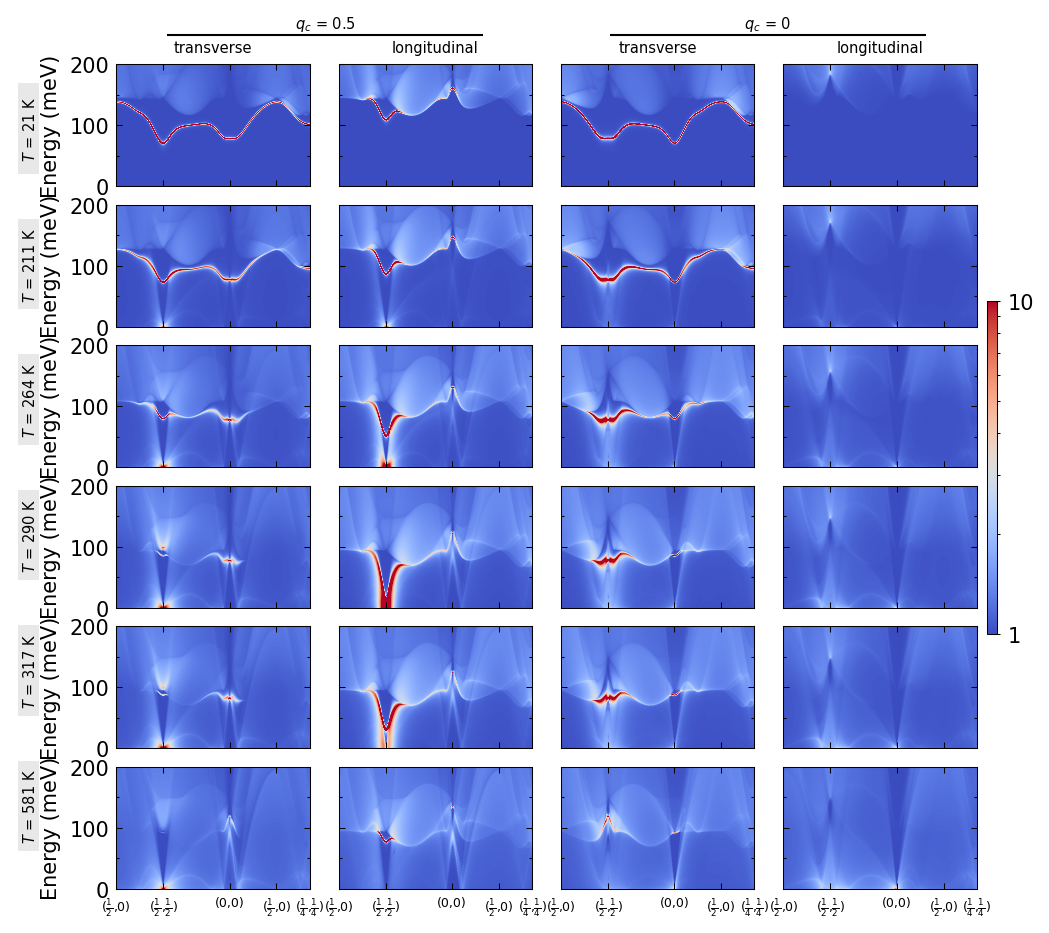

In [13]:
fig = plt.figure(figsize=[3.375*2, 3.375*1.8], dpi=150)

# Col titles
gs1 = fig.add_gridspec(nrows=1, ncols=2, left=0.15, right=0.9, top=0.99, bottom=0.965, wspace=0.4, hspace=0)
ax1 = [fig.add_subplot(gs) for gs in gs1]
for ax in ax1: ax.axis('off')
ax1[0].text(0.5, 1, '$q_c$ = 0.5', fontdict=dict(fontsize=7), transform=ax1[0].transAxes, horizontalalignment='center', verticalalignment='top')
ax1[0].set_ylim(-0.1,1)
ax1[0].axhline(y=0, lw=1, color='k')
ax1[1].text(0.5, 1, '$q_c$ = 0', fontdict=dict(fontsize=7), transform=ax1[1].transAxes, horizontalalignment='center', verticalalignment='top')
ax1[1].set_ylim(-0.1,1)
ax1[1].axhline(y=0, lw=1, color='k')

# Row titles
gs2 = fig.add_gridspec(nrows=6, ncols=1, left=0, right=0.03, top=0.935, bottom=0.05, hspace=0.05)
ax2 = [fig.add_subplot(gs) for gs in gs2]
for ax, T in zip(ax2, [21,211,264,290,317,581]):
    ax.axis('off')
    ax.text(0.5, 0.5, '$T$ = {:d} K'.format(T), fontdict=dict(fontsize=7), transform=ax.transAxes, horizontalalignment='center', verticalalignment='center', rotation=90)
    r1 = patches.Rectangle((0.1,0.15),0.7,0.7, color='lightgrey', alpha=0.5, lw=0, zorder=-1, transform=ax.transAxes)
    ax.add_patch(r1)

# Colorplot
gs3 = fig.add_gridspec(nrows=6, ncols=4, left=0.1, right=0.95, top=0.935, bottom=0.03, wspace=0.15, hspace=0.15)
ax3 = [fig.add_subplot(gs) for gs in gs3]
cmap = 'coolwarm'
extent = [Qv[0],Qv[-1],Ev[0],Ev[-1]]

for axA, axB, axC, axD, SQW in zip(ax3[::4], ax3[1::4], ax3[2::4], ax3[3::4], SQWs):
    for ax, SQW0 in zip([axC,axD,axA,axB], SQW):
        ax.imshow(SQW0*50.+1., origin='lower', extent=extent, aspect='auto', norm=colors.LogNorm(vmin=1, vmax=10), cmap=cmap)

# Adjust the axis
for ax, title in zip(ax3[:4], ['transverse', 'longitudinal','transverse', 'longitudinal']):
    ax.set_title(title, fontsize=7)

for ax in ax3:
    make_theme(ax, case=2)
    ax.set_ylim(0,200)
    ax.set_yticks([0, 100, 200])
    ax.set_xticks(Disp1['Qlabel'])
    ax.tick_params(labelleft=False, labelbottom=False)

for ax in ax3[::4]:
    ax.tick_params(labelleft=True)
    ax.set_ylabel('Energy (meV)')
    
for ax in ax3[-4:]:
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels([r'($\frac{1}{2}$,0)', r'($\frac{1}{2}$,$\frac{1}{2}$)', r'(0,0)', r'($\frac{1}{2}$,0)', r'($\frac{1}{4}$,$\frac{1}{4}$)'], fontsize=6)

# colorbar
gs4 = fig.add_gridspec(nrows=1, ncols=1, left=0.96, right=0.97, top=0.675, bottom=0.31)
ax4 = [fig.add_subplot(gs) for gs in gs4]
cbar = fig.colorbar(art, cax=ax4[0], format=ticker.LogFormatter(10, labelOnlyBase=True), ticks=np.arange(1,11))
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(width=0.5, length=1.5)
cbar.ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())